In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as opt
import torch.nn.functional as F


np.random.seed(42)

In [67]:
train_path_dir = '../../data/wesad_processed/wesad_train_scaled.csv'
test_path_dir = '../../data/wesad_processed/wesad_test_scaled.csv'

train_df = pd.read_csv(train_path_dir)
test_df = pd.read_csv(test_path_dir)

for u in train_df['user_id'].unique():
    length = len(train_df[train_df['user_id'] == u])
    print(f'user {u}: ', f'{length} samples')

user S10:  6372 samples
user S11:  6232 samples
user S13:  6228 samples
user S14:  6232 samples
user S15:  6248 samples
user S16:  6216 samples
user S17:  6368 samples
user S2:  5932 samples
user S3:  6032 samples
user S4:  6056 samples
user S5:  6200 samples
user S6:  6160 samples
user S7:  6152 samples
user S8:  6180 samples
user S9:  6148 samples


In [46]:
print('### Train dataset')
for label in train_df['label'].unique():
    t = np.sum(train_df['label'] == 0)
    print(f'label {label} has {t}')

print()
print('### Test dataset')
for label in test_df['label'].unique():
    t = np.sum(test_df['label'] == 0)
    print(f'label {label} has {t}')


### Train dataset
label 0 has 49296
label 1 has 49296
label 2 has 49296

### Test dataset
label 0 has 21148
label 1 has 21148
label 2 has 21148


<AxesSubplot:title={'center':'Test Dataset'}, ylabel='label'>

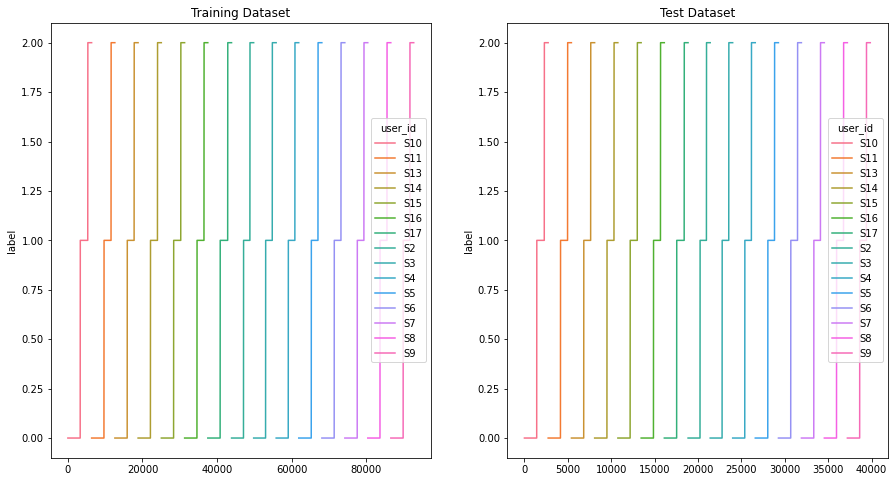

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.set_title('Training Dataset')
ax2.set_title('Test Dataset')

sns.lineplot(x = train_df.index, y = train_df['label'], hue=train_df['user_id'], ax=ax1)
sns.lineplot(x = test_df.index, y = test_df['label'], hue=test_df['user_id'], ax=ax2)

In [5]:
train_df.columns

Index(['chest_acc', 'chest_ecg', 'chest_emg', 'chest_eda', 'chest_temp',
       'chest_resp', 'wrist_acc', 'wrist_bvp', 'wrist_eda', 'wrist_temp',
       'label', 'user_id'],
      dtype='object')

In [6]:
cols = ['chest_acc', 'chest_ecg', 'chest_emg', 'chest_eda', 'chest_temp',
       'chest_resp', 'wrist_acc', 'wrist_bvp', 'wrist_eda', 'wrist_temp',]

for i in range(len(cols)):
    # sns.histplot(x=train_df[cols[i]], hue=train_df['user_id'], legend=False)
    plt.show()

In [7]:
for i in range(len(cols)):
    # sns.lineplot(x=train_df.index, y = train_df[cols[i]], hue=train_df['label'], legend=True)
    plt.show()

In [8]:
for i in range(len(cols)):
    # sns.scatterplot(x=train_df['chest_eda'], y = train_df[cols[i]], hue=train_df['label'], legend=True)
    plt.show()

In [9]:
kmeans = KMeans(3)

X = train_df.drop(['label', 'user_id'], axis=1)[train_df['user_id'] == 'S10']
kmeans.fit(X)

KMeans(n_clusters=3)

In [13]:
X['cluser_labels'] = kmeans.labels_
X['labels'] = train_df[train_df['user_id'] == 'S10']['label']

np.sum(X['cluser_labels'] == X['labels']) / len(X)

0.09447583176396736

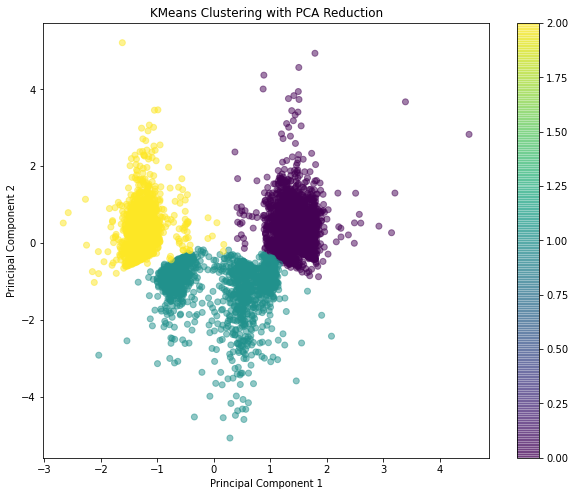

In [14]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualizing in a 2D plot
X_pca = pca.fit_transform(X)

# Assign clusters from KMeans to use as labels for coloring
clusters = kmeans.labels_

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('KMeans Clustering with PCA Reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()

In [47]:
def wesad_get_groups(df, method='simple', ngroup=3):
    '''
    Input: train or test DataFrame
    Return: Dictionary of groups and the corresponding index
    '''
    if method != 'simple':
        raise NotImplementedError

    groups = {g: [] for g in range(ngroup)}
    users = df['user_id'].unique()
    labels = df['label'].unique()

    for user in users:
        df_user = df[df['user_id'] == user]

        for l in labels:
            df_user_label = df_user[df_user['label'] == l]
            df_user_label_index = list(df_user_label.index)
            total_samples = len(df_user_label_index)
            nsamples = total_samples // ngroup
            leftover = total_samples % ngroup
                        
            start_index = 0
            for g in range(ngroup):
                if g < leftover:
                    # Give extra sample to this group
                    end_index = start_index + nsamples + 1
                else:
                    end_index = start_index + nsamples

                selected_indices = df_user_label_index[start_index:end_index]
                groups[g].extend(selected_indices)
                start_index = end_index

    return groups

In [56]:
def simulate_missing_modality(groups, p=0.5, run_idx = 1):
    def bernoulli_missingness(seed, size= 1, p = 0.5):
        np.random.seed(seed)
        return np.random.binomial(
            size = size,
            n = 1,
            p = p
        )


    group_info = {g : {} for g in groups.keys()}

    for group in groups.keys():
        group_info[group]['indexes'] = groups[group]

        # missingness for each modality (10)
        miss =list(bernoulli_missingness((group + 1) * run_idx, size=10, p=p))

        group_info[group]['missing_modalities'] = miss
    
    return group_info

In [ ]:
def load_dataset(run_idx=1, ngroups = 220, p=0.5):    

    train_df = pd.read_csv('../../data/wesad_processed/wesad_train_scaled.csv')
    test_df = pd.read_csv('../../data/wesad_processed/wesad_test_scaled.csv')

    train_groups = wesad_get_groups(train_df, ngroup=ngroups)
    train_groups_info = simulate_missing_modality(train_groups, run_idx=run_idx, p=p)

    for g in train_groups_info.keys():
        idxes  = train_groups_info[g]['indexes']
        missing = train_groups_info[g]['missing_modalities']

        cols = train_df.columns

        #simulate missing modalities
        for m in range(len(missing)):
            if missing[m] == 1:
                train_df.loc[idxes, cols[m]] = 0
                
    X_train, y_train = train_df.iloc[:, :-2].to_numpy(), train_df['label'].to_numpy()
    X_test, y_test = test_df.iloc[:, :-2].to_numpy(), test_df['label'].to_numpy()

    print(" ..reading instances: train {0}, test {1}".format(X_train.shape, X_test.shape))

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # The targets are casted to int8 for GPU compatibility.
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)

    return X_train, y_train, X_test, y_test